# Training an ANN to represent the gravity acceleration produced by a mascon
In this notebook we explore the possibility to use ANNs to represent the generic shape and density of an irregular body represented by a mascon model. 

The loss is defined on the prediction accuracy of the gravitational acceleration field.

To run this notebook (and the others) create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib jupyter
 conda activate geodesyann
 conda install -c pytorch pytorch
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
 conda install pyvista pyvistaqt
```

To use CUDA, you will need to run
```
 conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
```


In [2]:
# core stuff
import gravann
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Available devices  1
__pyTorch VERSION: 1.6.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing the ground truth asteroid (a point cloud)

In [28]:
with open("mascons/sample_06_cluster_6137.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

print("Name: ", mascon_name)
print("Number of points: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  sample_06_cluster_6137
Number of points:  249
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.21900972723960876


<IPython.core.display.Javascript object>


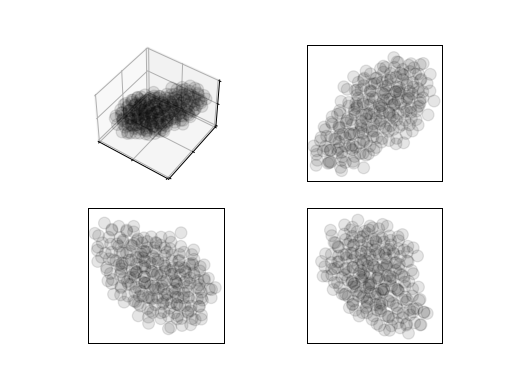

In [29]:
gravann.plot_mascon(mascon_points, mascon_masses)

In [ ]:
mesh = gravann.plot_point_cloud_mesh(mascon_points, use_top_k=5)

# Representing an asteroid via a neural network


## 1 - Instantiating the network
The networks inputs are the cartesian coordinates of a point in the unit cube, encoded via some transformation

In [ ]:
# Encoding choosen
encoding = gravann.direct_encoding()
model = gravann.init_network(encoding, n_neurons=100, model_type="default")

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init some loss trend indicators
weighted_average = deque([], maxlen=20)

In [ ]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
#model.load_state_dict(torch.load("results/run_02_11_2020/Churyumov-Gerasimenko.pk/LR=0.0001_loss=mse_loss_encoding=direct_encoding_batch_size=1000_target_sample=cubical_activation=Sigmoid/model.mdl"))

## Visualizing an asteroid represented by the network
The network output is the density in the unit cube. It is, essentially, a three dimensional function and as such it is difficult to plot. 

### Approach 1: plotting a grid of points colored with the rho value

In [ ]:
gravann.plot_model_grid(model, encoding, views_2d=False)
plt.title("Believe it or not I am an asteroid")

### Approach 2: considering rho as a probability density function and sampling points from it

In [ ]:
gravann.plot_model_rejection(model, encoding, views_2d=False, N=2500, progressbar=True, c=1)
plt.title("Believe it or not I am an asteroid")

# Training The ANN to match the ground truth potential

Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [ ]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Here we set some hyperparameters
N_mc_points = 400000
batch_size = 1000

# Here we set the loss
#loss_fn = gravann.mse_loss
loss_fn = gravann.contrastive_loss

# Here we set the choosen Integration method
#mc_method = gravann.ACC_ld
mc_method = gravann.ACC_trap

# Here we set the method to sample the target points
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/Churyumov-Gerasimenko.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])
# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.5, patience = 5000, min_lr = 5e-6,verbose=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,nesterov=True)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.5, step_size_up=250, mode="exp_range", gamma = .997)

In [ ]:
# This cell can be stopped and started again without loosing memory of the training nor its indicators
torch.cuda.empty_cache()

# The main training loop
for i in range(1000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
    labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
    # Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
    predicted = mc_method(target_points, model, encoding, N=N_mc_points)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((N_mc_points*batch_size) // 1000)
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

In [ ]:
# Rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True)

In [ ]:
# Plot the loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa, loss_log)
plt.semilogy(abscissa, weighted_average_log)
plt.xlabel("Thousands of model evaluations")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

In [ ]:
# Rejection plot overlayed with the mascon
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses,c=c, progressbar = True, N=2500, levels=[0.01,0.1, 0.2,0.3,0.4,0.5,0.6, 0.7,0.8,0.9,1.])

In [ ]:
# Generating a mesh out of the model
gravann.plot_model_mesh(model,encoding,rho_threshold=c.cpu().detach().numpy()*1e-2) 

In [ ]:
x,y,z = torch.meshgrid(torch.linspace(-1,1,10), torch.linspace(-1,1,10), torch.linspace(-1,1,10))
x = x.reshape((-1,1))
y = y.reshape((-1,1))
z = z.reshape((-1,1))
grid = torch.cat((x,y,z), axis=1)
grid

In [ ]:
min(model(grid)*c)

In [ ]:
labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
# Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
predicted = mc_method(target_points, model, encoding, N=N_mc_points)
c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)

In [ ]:
c

#### Saving the model

In [ ]:
# Uncomment to save to models/cluster_xxxx
#torch.save(model.state_dict(), "models/" + name + "_" + encoding.name + "_ACC.mdl")

# TODO list:

* Code efficiency -> move to GPU and make training scalable to more sample points / mc points.
* MC integration -> importance sampling maybe?
* Network architecture -> study different encodings
* How to visualize and interpret the results quantitatively.
* Propagate trajectories around the asteroids (ground truth and trained).
* Incorporate visual cues.
* Training with gravity rather than potential?
* What happens for non uniform bodies?